In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import csv

### Load data and processing

In [2]:

open_train_body = open('train_bodies.csv', 'r', encoding='utf-8')
train_body = csv.DictReader(open_train_body)

articles = []
for i in train_body:
    
    bid = int(i['Body ID'])
    if (bid + 1) > len(articles):   
        articles += [None] * (bid + 1 - len(articles))
    articles[bid] = i['articleBody']
    
open_train_body.close()




data_unrelated =[]
data_discuss = []
data_agree = []
data_disagree = []

open_stances = open('train_stances.csv', 'r', encoding='utf-8')
all_stances = csv.DictReader(open_stances)

for i in all_stances:
    
    b = articles[int(i['Body ID'])]
    if i['Stance'] == 'unrelated':
        data_unrelated.append((i['Headline'], b, i['Stance']))
    elif i['Stance'] == 'discuss':
        data_discuss.append((i['Headline'], b, i['Stance']))
    elif i['Stance'] == 'agree':
        data_agree.append((i['Headline'], b, i['Stance']))
    
    elif i['Stance'] == 'disagree':
        data_disagree.append((i['Headline'], b, i['Stance']))

open_stances.close()

In [3]:
ind_b = {articles[i]: i for i in range(len(articles))}

In [4]:
#print(data_unrelated[0][0])   # headline
#print(data_unrelated[0][1])   # body
print(len(data_disagree))    # stance  [0][2]

840


### Split data into training set and validation set

In [5]:

def split(inp):
    train_len = int( len(inp) * 0.9)
    train = inp[0:train_len]
    val = inp[train_len:]
    
    return train,val


agree_train, agree_val = split(data_agree)
disagree_train, disagree_val = split(data_disagree)
discuss_train,discuss_val = split(data_discuss)
unrelated_train,unrelated_val = split(data_unrelated)


In [6]:
train_data = agree_train + disagree_train + discuss_train + unrelated_train   #order: agree, disgree, discuss, unrelated
random.Random(0).shuffle(train_data)
train_data = np.array(train_data)

val_data = agree_val + disagree_val + discuss_val + unrelated_val
random.Random(0).shuffle(val_data)
val_data = np.array(val_data)

In [7]:
print("Proportion of agree: ", len(agree_train)/len(agree_val))
print("Proportion of disagree: ", len(disagree_train)/len(disagree_val))
print("Proportion of discuss: ", len(discuss_train)/len(discuss_val))
print("Proportion of unrelated: ", len(unrelated_train)/len(unrelated_val))

print("***********************************************")
print('\tAgree \tDisag \tDiscus \tUnrela \tAll')

print('FUll\t',len(data_agree), '\t',len(data_disagree),'\t', len(data_discuss),'\t', len(data_unrelated), '\t', np.shape(train_data)[0]+ np.shape(val_data)[0])
print('Train\t', len(agree_train), '\t', len(disagree_train), '\t', len(discuss_train), '\t', len(unrelated_train),'\t',np.shape(train_data)[0])
print('Val\t', len(agree_val), '\t', len(disagree_val), '\t', len(discuss_val), '\t', len(unrelated_val),'\t',np.shape(val_data)[0])


Proportion of agree:  8.994565217391305
Proportion of disagree:  9.0
Proportion of discuss:  8.998877665544333
Proportion of unrelated:  8.998632010943913
***********************************************
	Agree 	Disag 	Discus 	Unrela 	All
FUll	 3678 	 840 	 8909 	 36545 	 49972
Train	 3310 	 756 	 8018 	 32890 	 44974
Val	 368 	 84 	 891 	 3655 	 4998


### Vector representation and cosine similarity

In [8]:
from tqdm import tqdm
# Use GLoVe representation
glove = open("glove.6B.50d.txt", "rb")  
vector_g = {}
for i in tqdm(glove):
    vector_g[str(i.split()[0]).split("'")[1]] = np.array(list(map(float, i.split()[1:])))


400000it [00:06, 64400.19it/s]


In [9]:
#process test data

open_test_body = open('competition_test_bodies.csv', 'r', encoding='utf-8')
test_body = csv.DictReader(open_test_body)

articlestest = []
for i in test_body:
    
    bid = int(i['Body ID'])
    if (bid + 1) > len(articlestest):   
        articlestest += [None] * (bid + 1 - len(articlestest))
    articlestest[bid] = i['articleBody']
    
open_test_body.close()


testdata_unrelated =[]
testdata_discuss = []
testdata_agree = []
testdata_disagree = []

testopen_stances = open('competition_test_stances.csv', 'r', encoding='utf-8')
testall_stances = csv.DictReader(testopen_stances)

for i in testall_stances:
    
    b = articlestest[int(i['Body ID'])]
    if i['Stance'] == 'unrelated':
        testdata_unrelated.append((i['Headline'], b, i['Stance']))
    elif i['Stance'] == 'discuss':
        testdata_discuss.append((i['Headline'], b, i['Stance']))
    elif i['Stance'] == 'agree':
        testdata_agree.append((i['Headline'], b, i['Stance']))
    
    elif i['Stance'] == 'disagree':
        testdata_disagree.append((i['Headline'], b, i['Stance']))

testopen_stances.close()

In [10]:
test_ind_b = {articlestest[i]: i for i in range(len(articlestest))}

In [11]:
test_data = testdata_agree + testdata_disagree + testdata_discuss + testdata_unrelated   #order: agree, disgree, discuss, unrelated
random.Random(0).shuffle(test_data)
test_data = np.array(test_data)


In [12]:
print(test_data.shape[0])

25413


In [13]:
#form corpus by combining train, validation and test data
C = np.r_[train_data[:, 1], train_data[:, 0],val_data[:, 1], val_data[:, 0],test_data[:, 1], test_data[:, 0]]  

In [14]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [15]:
V_tfidf = TfidfVectorizer(stop_words='english')
tfidf = V_tfidf.fit_transform(C)
# Create index of column indices in tf_idf -> word
tfidf_mapping = {i[1]: i[0] for i in V_tfidf.vocabulary_.items()}

In [16]:
print(tfidf.shape)  #

(150770, 29148)


In [17]:
# this function convert documents to vectors
def doc_to_vector(d):
    
    documents = V_tfidf.transform([d])
    
    _, ind = documents[0].nonzero()
    outputs = np.array([0.0] * 50)
    total = 0
    
    for i in ind:
        w = tfidf_mapping[i]
        if w in vector_g:
            outputs += vector_g[w] * documents[0, i]
            total += documents[0, i]
    outputs /= total
    
    return outputs



In [18]:
print(train_data[0][0])
print(doc_to_vector(train_data[0][0]))

UK spies identify Foley’s killer, Abdel-Majed Abdel Bary a key suspect
[-0.08676952 -0.07428999  0.19578008  0.11451261  0.51394369 -0.14461766
 -0.28815765  0.12675044  0.10860505  0.14668026  0.26397496  0.2061046
 -0.44428977  0.40140098  0.13119332 -0.16166526 -0.07760272 -0.30664819
  0.20275505  0.39050331 -0.22558035  0.41765185  0.51413314  0.28447866
 -0.3131521  -1.11402264  0.07045213 -0.32427004  0.22081831  0.03088698
  0.9422806  -0.46842919 -0.50857077 -0.28569984  0.60048897  0.14271825
  0.05295646 -0.00945297 -0.080992    0.61298732 -0.00902879  0.38732832
  0.24368407 -0.04531722  0.81273493 -0.35468004 -0.51126964  0.26762985
  0.47696889 -0.09036701]


In [19]:
from scipy.spatial.distance import cosine
# this function is used to compute cosine similarity 
def COS(d):
    cos = cosine(doc_to_vector(d[0]), doc_to_vector(d[1]))
    similarity = 1.0 - cos
    
    return similarity


In [20]:
def calculation(d,f):
    
    output = f(d)
    return output

In [21]:
# calculate cosine similarity of all headlines and bodies
cosine_similarity = np.array([calculation(d,COS) for d in tqdm(train_data)])

100%|██████████| 44974/44974 [07:35<00:00, 98.72it/s]


In [22]:
cosine_similarity.shape

(44974,)

In [23]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
labels = encoder.fit_transform(list(train_data[:, 2]))
print(labels.shape)

(44974,)


In [24]:
labels[0:50]

array([3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 1, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3,
       3, 3, 3, 3, 3, 3])

In [25]:
cos_agree = []
cos_disagree = []
cos_discuss = []
cos_unrelated = []
for i in range(labels.shape[0]):
    if labels[i] == 0:
        cos_agree.append(cosine_similarity[i])
    elif labels[i] == 1:
        cos_disagree.append(cosine_similarity[i])
    elif labels[i] == 2:
        cos_discuss.append(cosine_similarity[i])
    elif labels[i] == 3:
        cos_unrelated.append(cosine_similarity[i])
        
     

In [26]:
len(cos_discuss)

8018

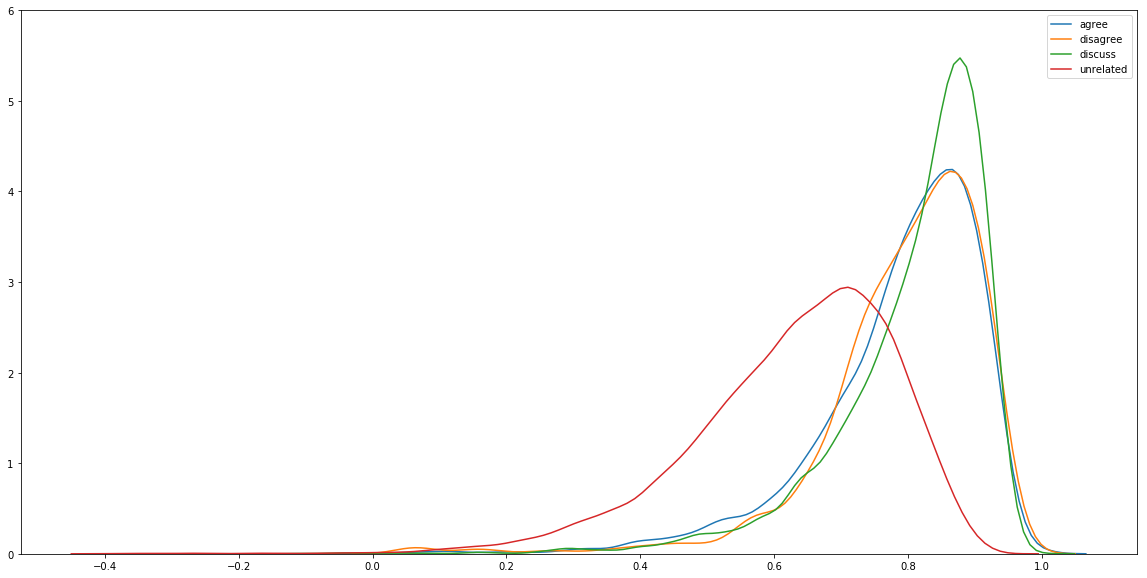

In [27]:
import seaborn as sns
plt.figure(figsize=(20,10))
plt.ylim((0, 6))
sns.kdeplot(cos_agree, label='agree')
sns.kdeplot(cos_disagree, label='disagree')
sns.kdeplot(cos_discuss, label='discuss')
sns.kdeplot(cos_unrelated, label='unrelated')
plt.show()

In [28]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 


### Language Model and KL-divergence 

In [29]:
# this function defines language model
def language_model(data, b, m):

    model = np.zeros([len(m), len(m)])
    
    a = b.sum() / len(data)
    
    for i in range(len(m)):
        count = len(data.iloc[1])
        c = m[i].sum()
        model[i] = count / (a + count) * m[i] / c + a / (a + count) * b
        
    return model

In [30]:
# this function calculate kl divergence
def entropy(head_lm, body_lm):
    output = 0
    for i in range(head_lm.shape[0]):  
        output += head_lm[i] * np.log(head_lm[i] / body_lm[i])
        
    return output


def kl(d):
    cv = CountVectorizer(stop_words='english')
    V_data = cv.fit_transform([d[0], d[1]])
    head_v = np.squeeze(np.array(V_data[0].todense()))
    body_v = np.squeeze(np.array(V_data[1].todense()))
    
    H = (head_v + 0.1) / np.sum(head_v)  # add a small value for smoothing.
    B = (body_v + 0.1) / np.sum(body_v)
    
    output = entropy(H,B)
    return output



In [31]:
# calculate kl divergence of all headlines and bodies
kl_divergence = np.array([calculation(d,kl) for d in tqdm(train_data)])

100%|██████████| 44974/44974 [01:18<00:00, 574.84it/s]


In [32]:
kl_agree = []
kl_disagree = []
kl_discuss = []
kl_unrelated = []

for i in range(labels.shape[0]):
    if labels[i] == 0:
        kl_agree.append(kl_divergence[i])
    elif labels[i] == 1:
        kl_disagree.append(kl_divergence[i])
    elif labels[i] == 2:
        kl_discuss.append(kl_divergence[i])
    elif labels[i] == 3:
        kl_unrelated.append(kl_divergence[i])

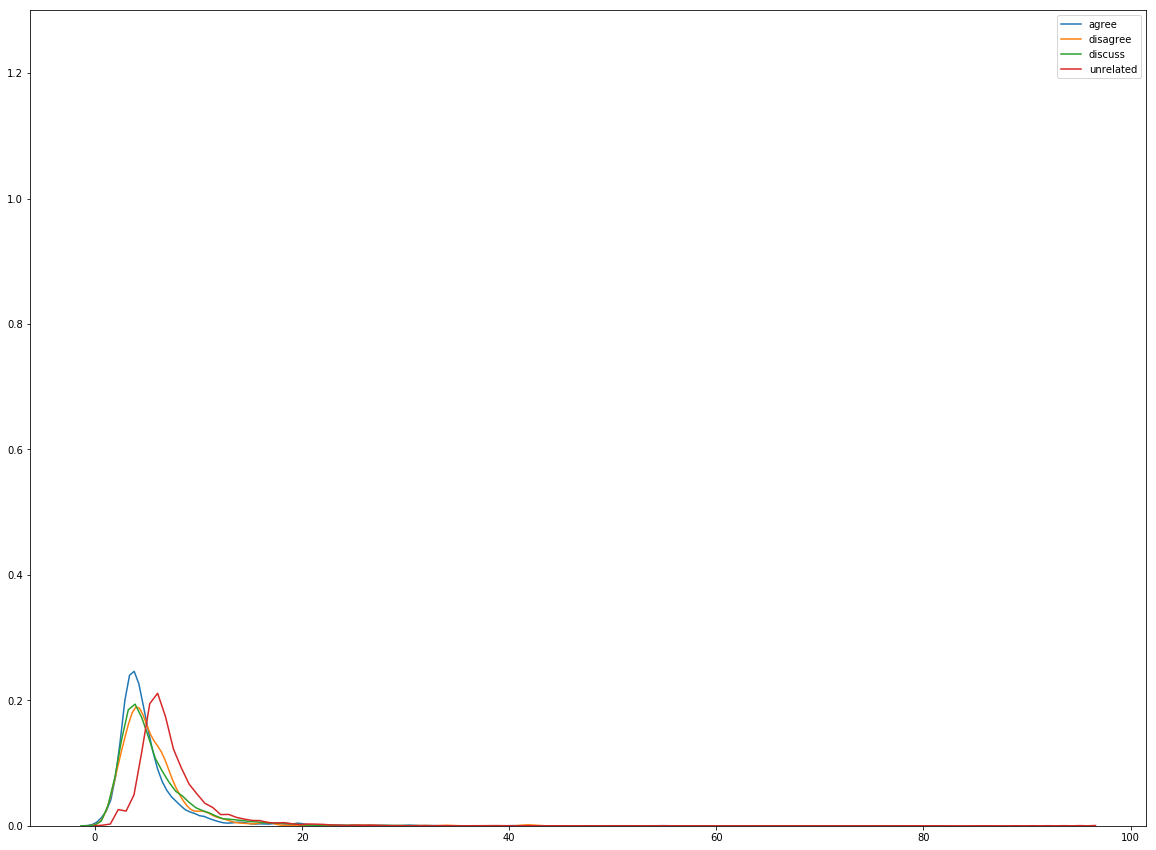

In [33]:
plt.figure(figsize=(20,15))
plt.ylim((0, 1.3))
sns.kdeplot(kl_agree, label='agree')
sns.kdeplot(kl_disagree, label='disagree')
sns.kdeplot(kl_discuss, label='discuss')
sns.kdeplot(kl_unrelated, label='unrelated')
plt.show()

### Alternative features

In [34]:
# this function calculate n-gram
def n_gram(d):
    cv = CountVectorizer(stop_words='english', ngram_range=(1, 3))
    cv.fit([d[0]])
    b_v = cv.transform([d[1]])
    
    res = np.sum(b_v) / len(d[1])
    res1 = 1 / np.e
    f = np.power(res, res1)
    return f
    


In [35]:
# calculate n-gram of all headlines and bodies
ngram_f = np.array([calculation(d,n_gram) for d in tqdm(train_data)])

100%|██████████| 44974/44974 [01:16<00:00, 591.65it/s]


In [36]:
ngram_agree = []
ngram_disagree = []
ngram_discuss = []
ngram_unrelated = []

for i in range(labels.shape[0]):
    if labels[i] == 0:
        ngram_agree.append(ngram_f[i])
    elif labels[i] == 1:
        ngram_disagree.append(ngram_f[i])
    elif labels[i] == 2:
        ngram_discuss.append(ngram_f[i])
    elif labels[i] == 3:
        ngram_unrelated.append(ngram_f[i])

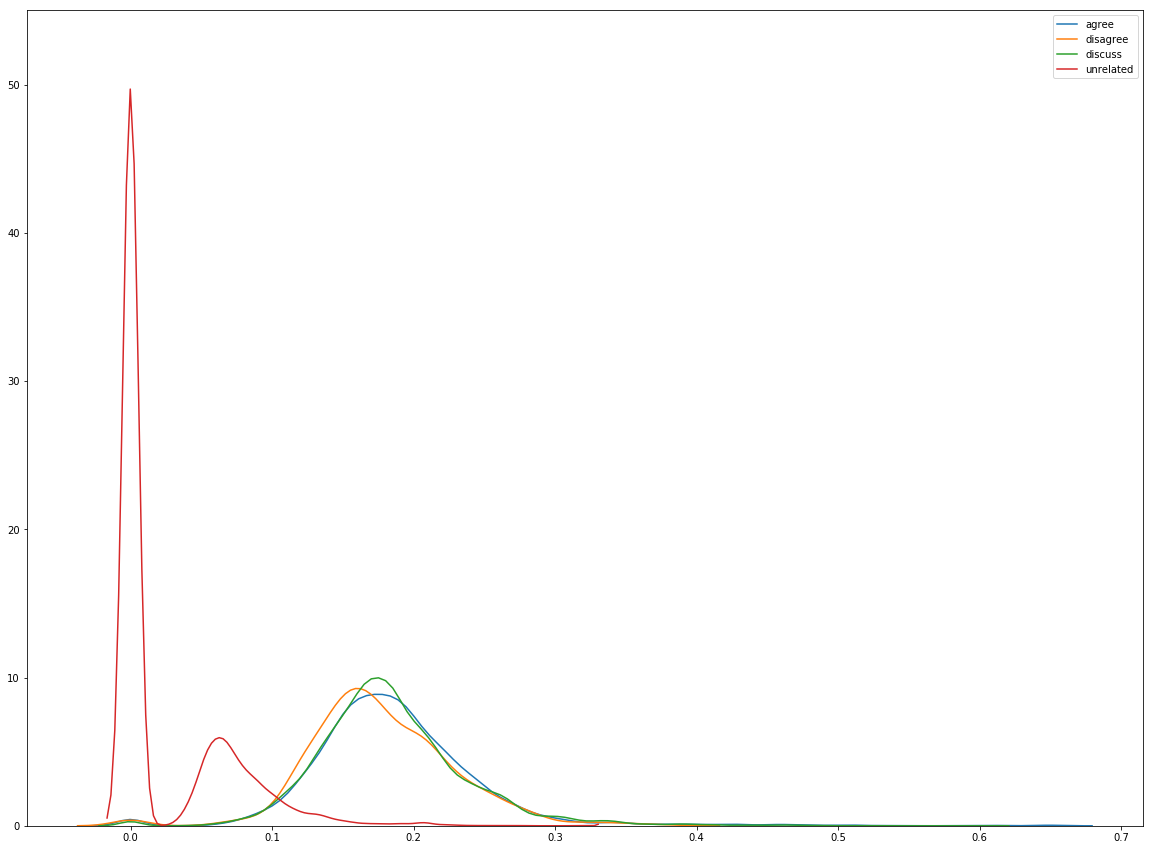

In [37]:
plt.figure(figsize=(20,15))
plt.ylim((0, 55))
sns.kdeplot(ngram_agree, label='agree')
sns.kdeplot(ngram_disagree, label='disagree')
sns.kdeplot(ngram_discuss, label='discuss')
sns.kdeplot(ngram_unrelated, label='unrelated')
plt.show()

In [38]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
ana = SentimentIntensityAnalyzer()

In [39]:

def feature2(d):
    output = np.absolute(ana.polarity_scores(d[0])['compound'] - ana.polarity_scores(d[1])['compound'])
    return output

In [40]:
f2 = np.array([calculation(d,feature2) for d in tqdm(train_data)])

100%|██████████| 44974/44974 [03:17<00:00, 227.55it/s]


In [41]:
f2_agree = []
f2_disagree = []
f2_discuss = []
f2_unrelated = []

for i in range(labels.shape[0]):
    if labels[i] == 0:
        f2_agree.append(f2[i])
    elif labels[i] == 1:
        f2_disagree.append(f2[i])
    elif labels[i] == 2:
        f2_discuss.append(f2[i])
    elif labels[i] == 3:
        f2_unrelated.append(f2[i])

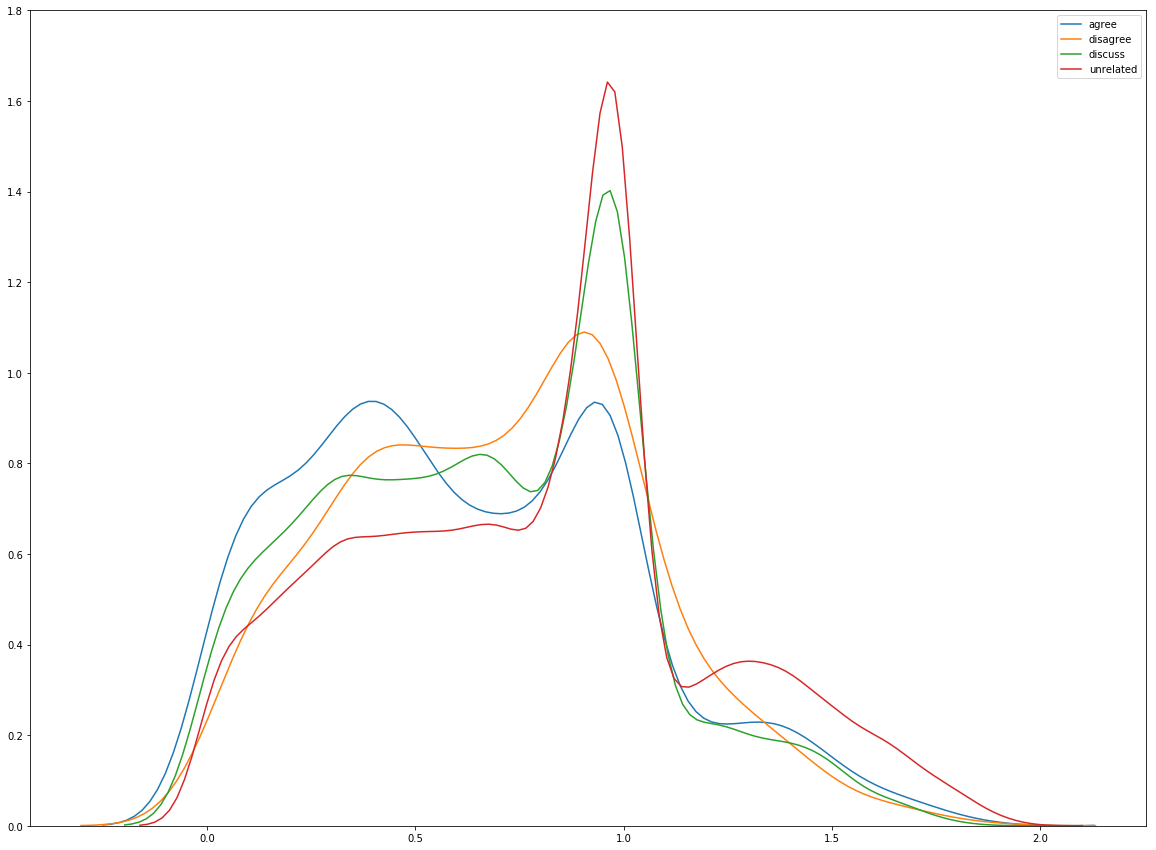

In [42]:
plt.figure(figsize=(20,15))
plt.ylim((0, 1.8))
sns.kdeplot(f2_agree, label='agree')
sns.kdeplot(f2_disagree, label='disagree')
sns.kdeplot(f2_discuss, label='discuss')
sns.kdeplot(f2_unrelated, label='unrelated')
plt.show()

### Logistic regression

In [43]:
def sigmoid(x):
    out = 1. / (1 + np.exp(-x))
    return out
    
def softmax(x):
    mx = np.amax(x,axis=1,keepdims = True)
    x_exp = np.exp(x - mx)
    x_sum = np.sum(x_exp, axis = 1, keepdims = True)
    res = x_exp / x_sum
    return res


In [43]:
class LR():
    
    def __init__(self, C = 1, lr=0.01, n_iteration=100, batch_size=100):
        
        self.C = C
        self.lr = lr
        self.n_iteration = n_iteration
        self.batch_size = batch_size
        self.w = []
        self.b = []
        
    
    
    def train(self, x, y):
        
        s1 = x.shape[0]
        s2 = X.shape[1]
        w = np.zeros([s1, 1])
        b = 0
        
        batch = []
        for i in range(self.batch_size ):
            s = i * self.batch_size
            f = (i + 1) * self.batch_size
            
            batch.append(range(s, f))
            
        
        s = (self.n_batch - 1) * self.batch_size
        f = s2
        
        batch.append(range(s, f))
            
        for i in range(self.n_iteration):
            l = 0
            
            for j in range(self.n_batch):
                
                x_t = x[batch[j]]
                y_t = y[batch[j]]
                
                s = x_t.shape[0]
                al = np.dot(x_t, w) + b
                d = sigmoid(al)
                
                loss = 0.5 * ((- y_t) * np.log(d) - (1-y_t) * sum(np.log(1 - d))) + 1/2 * self.C * sum(np.square(w))
                dd = np.average(d - y_t)
                g_w = (np.average((x_t * (d - y_t)), axis=0)).reshape(-1,1) + self.C * w
                g_b = dz
                w = w - self.lr * g_w
                b = b - self.lr * g_b
                
                l += loss
            l  = l/ s2

        return w, b
            
        
    def fit(self, x, y):
        self.w = []
        self.b = []
        num = y.shape[1]
        for i in range(num):
            w, b = self.train(x, y[:,i].reshape(-1,1))
            self.w.append(w)
            self.b.append(b)
                
    
    def predict(self, x):
        out = np.zeros_like(p)
        m = p.argmax(axis=1)
        for i in range(x.shape[0]):
            out[i][m[i]] = 1
            
        return out
    

In [44]:
functions = [COS, kl, n_gram]

def make_features(d):
    output = np.array([0.0] * len(functions))
    for i in range(len(functions)):
        output[i] = functions[i](d)
        
    return output

#training set
training = np.array([make_features(d) for d in tqdm(train_data)])


100%|██████████| 44974/44974 [09:59<00:00, 74.97it/s]


In [45]:
print(training[:10])

[[0.62002921 1.16514479 0.04003387]
 [0.71510993 1.52449986 0.        ]
 [0.65809856 2.11522406 0.10452378]
 [0.87445548 0.47428184 0.14913028]
 [0.72389466 1.34724005 0.        ]
 [0.74238242 1.567045   0.        ]
 [0.59763309 2.10423226 0.        ]
 [0.79358543 1.76109303 0.        ]
 [0.71847206 1.08183975 0.        ]
 [0.54784081 1.77695722 0.        ]]


In [47]:
#validation set
testing = np.array([make_features(d) for d in tqdm(val_data)])

100%|██████████| 4998/4998 [01:11<00:00, 70.01it/s]


In [46]:
from sklearn.linear_model import LogisticRegression as LR

In [48]:
clf = LR(C=1e2, random_state=0, multi_class='multinomial', solver='saga')
clf.fit(training, labels)

LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=0, solver='saga',
          tol=0.0001, verbose=0, warm_start=False)

In [45]:
predict2 = clf.predict(testing)

NameError: name 'clf' is not defined

In [50]:
predict2

array([3, 3, 2, ..., 2, 3, 3])

In [51]:
p = encoder.inverse_transform(predict2)
bid = [str(ind_b[i]) for i in val_data[:, 1]]
n1 = np.array([{'Headline': val_data[i, 0], 'Body ID': bid[i], 'Stance': p[i]} for i in range(len(val_data))])
n2 = np.array([{'Headline': val_data[i, 0], 'Body ID': bid[i], 'Stance': val_data[i, 2]} for i in range(len(val_data))])

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [54]:
n2

array([{'Headline': 'No, Banksy hasn’t been arrested', 'Body ID': '1544', 'Stance': 'unrelated'},
       {'Headline': 'Experts: More facts needed on purported audio recording of Michael Brown shooting', 'Body ID': '456', 'Stance': 'unrelated'},
       {'Headline': "Urgent: The Leader of ISIL 'Abu Bakr al-Baghdadi' Killed! / Photo", 'Body ID': '1645', 'Stance': 'discuss'},
       ...,
       {'Headline': "Penis Drawn On Bugatti Veyron Could Be World's Most Expensive Car Vandalism", 'Body ID': '2369', 'Stance': 'agree'},
       {'Headline': 'Kurds fear Isis use of chemical weapon in Kobani', 'Body ID': '2280', 'Stance': 'unrelated'},
       {'Headline': "'Spiderman' squished: Perth experts debunk spider burrowing claims", 'Body ID': '43', 'Stance': 'unrelated'}],
      dtype=object)

In [52]:
from scorer import score_submission, print_confusion_matrix, score_defaults, SCORE_REPORT
test_score, cm = score_submission(n2, n1)
null_score, max_score = score_defaults(n2)
print_confusion_matrix(cm)
print(SCORE_REPORT.format(max_score, null_score, test_score))

CONFUSION MATRIX:
-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |     0     |     0     |    340    |    28     |
-------------------------------------------------------------
| disagree  |     0     |     0     |    72     |    12     |
-------------------------------------------------------------
|  discuss  |     1     |     0     |    820    |    70     |
-------------------------------------------------------------
| unrelated |     0     |     0     |    67     |   3588    |
-------------------------------------------------------------
ACCURACY: 0.882

MAX  - the best possible score (100% accuracy)
NULL - score as if all predicted stances were unrelated
TEST - score based on the provided predictions

||    MAX    ||    NULL   ||    TEST   ||
||  2256.75  ||  913.75   ||  1820.25  ||



### Linear regression

In [327]:
class linear_regression():
    
    def __init__(self, C = 1, lr = 0.01, n_iteration=100, batch_size=100):
        
        self.C = C
        self.lr = lr
        self.n_iteration = n_iteration
        self.batch_size = batch_size
        self.w = 0
        self.b = 0
        
    def train(self, x, y):
        
        s1 = x.shape[0]
        s2 = x.shape[1]
        self.w = np.random.random([s1,1])
        self.b = 0
        
        batch = []
        
        for i in range(self.n_batch - 1):
            s = i * self.batch_size
            f = (i + 1) * self.batch_size
            batch.append(range(s, f))
            
        s = (self.n_batch - 1) * self.batch_size
        f = s2
        
        batch.append(range(s, f))
        
        for i in range(self.n_iteration):
            l = 0
            
            for j in range(self.n_batch):
                
                x_t = x[batch[j]]
                y_tn = y[batch[j]]
                s = x_t.shape[0]
                al = np.matmul(x_t, self.w) + self.b
                
                diff = al - y_t
                loss = 0.5 * np.matmul(diff.T, diff) + 1/2 * self.C * np.sum(np.square(self.w))
                
                dd = np.average(al - y_t)
                g_w = self.C * self.w + 1. / s *(np.matmul(x_t.T, (al - y_t))) 
                g_b = dd
                
                self.w = self.w - self.lr * g_w
                self.b = self.b - self.lr * g_b
                
                l = l + loss
            l = l / s2
        
        return
    
    def fit(self, x, y):
        self.train(x, y)
        
    def predict(self, x):
        res = self.b + np.matmul(x, self.w)
        
        return res

In [ ]:

clf1 = linear_regression()
clf1.fit(training, labels)

In [138]:
predict1 = clf1.predict(testing)

In [328]:
predict1

array([3, 3, 2, ..., 2, 2, 3])

In [139]:
predict1_round = []
for i in predict1:
    predict1_round.append(int(round(i)))
predict1= np.array(predict1_round)

In [140]:
p1 = encoder.inverse_transform(predict1)
bid1 = [str(ind_b[i]) for i in val_data[:, 1]]
l1 = np.array([{'Headline': val_data[i, 0], 'Body ID': bid1[i], 'Stance': p1[i]} for i in range(len(val_data))])
l2 = np.array([{'Headline': val_data[i, 0], 'Body ID': bid1[i], 'Stance': val_data[i, 2]} for i in range(len(val_data))])

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [141]:
from scorer import score_submission, print_confusion_matrix, score_defaults, SCORE_REPORT
test_score1, cm1 = score_submission(l2, l1)
null_score1, max_score1 = score_defaults(l2)
print_confusion_matrix(cm1)
print(SCORE_REPORT.format(max_score1, null_score1, test_score1))

CONFUSION MATRIX:
-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |     1     |    101    |    264    |     2     |
-------------------------------------------------------------
| disagree  |     0     |    20     |    62     |     2     |
-------------------------------------------------------------
|  discuss  |     6     |    202    |    671    |    12     |
-------------------------------------------------------------
| unrelated |     0     |     4     |    422    |   3229    |
-------------------------------------------------------------
ACCURACY: 0.785

MAX  - the best possible score (100% accuracy)
NULL - score as if all predicted stances were unrelated
TEST - score based on the provided predictions

||    MAX    ||    NULL   ||    TEST   ||
||  2256.75  ||  913.75   ||  1658.0   ||



### Analyse the performance of your models using the test set

In [ ]:
#process test data

In [142]:
# test set features
competition_test = np.array([make_features(d) for d in tqdm(test_data)])

  0%|          | 21/25413 [00:00<08:48, 48.03it/s]/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
100%|██████████| 25413/25413 [05:24<00:00, 78.24it/s]


In [204]:
competition_test.shape

(25413, 3)

In [194]:
# remove data include nan
nanlist = np.where(np.isnan(competition_test))
#list(nanlist[0])
competition_test = np.delete(competition_test, list(nanlist[0]) ,axis = 0)


In [329]:
np.isnan(competition_test).any()

False

In [330]:
competition_test.shape

(25370, 3)

In [215]:
test_data.shape

(25413, 3)

In [216]:
test_data = np.delete(test_data, list(nanlist[0]) ,axis = 0)

In [217]:
test_data.shape

(25370, 3)

In [ ]:
# Logistic

In [210]:
testpredict2 = clf.predict(competition_test)

In [223]:
tp = encoder.inverse_transform(testpredict2)
bid_t = [str(test_ind_b [i]) for i in test_data[:, 1]]
tn1 = np.array([{'Headline': test_data[i, 0], 'Body ID': bid_t[i], 'Stance': tp[i]} for i in range(len(test_data))])
tn2 = np.array([{'Headline': test_data[i, 0], 'Body ID': bid_t[i], 'Stance': test_data[i, 2]} for i in range(len(test_data))])

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [224]:
from scorer import score_submission, print_confusion_matrix, score_defaults, SCORE_REPORT
test_score, cm = score_submission(tn2, tn1)
null_score, max_score = score_defaults(tn2)
print_confusion_matrix(cm)
print(SCORE_REPORT.format(max_score, null_score, test_score))

CONFUSION MATRIX:
-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |     6     |     0     |   1668    |    229    |
-------------------------------------------------------------
| disagree  |     0     |     0     |    517    |    180    |
-------------------------------------------------------------
|  discuss  |    16     |     0     |   3944    |    488    |
-------------------------------------------------------------
| unrelated |     5     |     0     |    298    |   18019   |
-------------------------------------------------------------
ACCURACY: 0.866

MAX  - the best possible score (100% accuracy)
NULL - score as if all predicted stances were unrelated
TEST - score based on the provided predictions

||    MAX    ||    NULL   ||    TEST   ||
||  11628.5  ||  4580.5   ||  9005.0   ||



In [ ]:
# Linear

In [225]:
testpredict1 = clf1.predict(competition_test)

In [227]:
testpredict1_round = []
for i in testpredict1:
    testpredict1_round.append(int(round(i)))
testpredict1 = np.array(testpredict1_round)

In [234]:
#There are some results not in list [0,1,2,3], we need to process them
a = [0,1,2,3]
for i in range(testpredict1.shape[0]):
    if testpredict1[i] not in a:
        testpredict1[i] = 3

In [332]:
testpredict1.shape[0]

25370

In [235]:
tp1 = encoder.inverse_transform(testpredict1)
bid_t = [str(test_ind_b [i]) for i in test_data[:, 1]]
tl1 = np.array([{'Headline': test_data[i, 0], 'Body ID': bid_t[i], 'Stance': tp1[i]} for i in range(len(test_data))])
tl2 = np.array([{'Headline': test_data[i, 0], 'Body ID': bid_t[i], 'Stance': test_data[i, 2]} for i in range(len(test_data))])

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [309]:
from scorer import score_submission, print_confusion_matrix, score_defaults, SCORE_REPORT
test_score, cm = score_submission(tl2, tl1)
null_score, max_score = score_defaults(tl2)
print_confusion_matrix(cm)
print(SCORE_REPORT.format(max_score, null_score, test_score))

CONFUSION MATRIX:
-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |     9     |    354    |   1487    |    53     |
-------------------------------------------------------------
| disagree  |     0     |    85     |    564    |    48     |
-------------------------------------------------------------
|  discuss  |    37     |   1062    |   3251    |    98     |
-------------------------------------------------------------
| unrelated |     0     |    15     |   1731    |   16576   |
-------------------------------------------------------------
ACCURACY: 0.785

MAX  - the best possible score (100% accuracy)
NULL - score as if all predicted stances were unrelated
TEST - score based on the provided predictions

||    MAX    ||    NULL   ||    TEST   ||
||  11628.5  ||  4580.5   ||  8365.0   ||



### Neural Network Model


In [58]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import Adam

/Applications/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [243]:
competition_test.shape

(25370, 3)

In [255]:
labels.shape

(44974,)

In [248]:
# transfer label into 4 dimensional vector which can be used in neural network

In [252]:
y = np.zeros((labels.shape[0],4))
for i in range(labels.shape[0]):
    index = labels[i]
    y[i][index] = 1

In [253]:
y

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

In [59]:
# construct and train NN model 
model = Sequential()

model.add(Dense(128, input_dim = 3))
model.add(Activation('relu'))
model.add(Dropout(0.7))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(4))
model.add(Activation('softmax'))

#complie
model.compile(loss='categorical_crossentropy', metrics=['acc'], optimizer='Adam')
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               512       
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
activation_2 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 260       
__________

In [318]:
nn_predict = model.predict(competition_test)

In [319]:
nn_predict.shape

(25370, 4)

In [ ]:
# transfer 4 dimensional results into 1 dimensional results

In [320]:
nn_prediction = []

for i in range(nn_predict.shape[0]):
    nn_prediction.append(int(np.argmax(nn_predict[i])))
    
nn_p = np.array(nn_prediction)

In [322]:
nnp = encoder.inverse_transform(nn_p)
bid_nn = [str(test_ind_b [i]) for i in test_data[:, 1]]
nn_n1 = np.array([{'Headline': test_data[i, 0], 'Body ID': bid_nn[i], 'Stance': nnp[i]} for i in range(len(test_data))])
nn_n2 = np.array([{'Headline': test_data[i, 0], 'Body ID': bid_nn[i], 'Stance': test_data[i, 2]} for i in range(len(test_data))])

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [323]:
test_score, cm = score_submission(nn_n2, nn_n1)
null_score, max_score = score_defaults(nn_n2)
print_confusion_matrix(cm)
print(SCORE_REPORT.format(max_score, null_score, test_score))

CONFUSION MATRIX:
-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |     0     |     0     |   1696    |    207    |
-------------------------------------------------------------
| disagree  |     0     |     0     |    526    |    171    |
-------------------------------------------------------------
|  discuss  |     0     |     0     |   4015    |    433    |
-------------------------------------------------------------
| unrelated |     0     |     0     |    339    |   17983   |
-------------------------------------------------------------
ACCURACY: 0.867

MAX  - the best possible score (100% accuracy)
NULL - score as if all predicted stances were unrelated
TEST - score based on the provided predictions

||    MAX    ||    NULL   ||    TEST   ||
||  11628.5  ||  4580.5   ||  9066.25  ||

